In [2]:
%load_ext autoreload
%autoreload 2

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, linalg
import healpy as hp
import emcee, tqdm, corner
import scipy.optimize

In [68]:
nside=64

## Initialise logit probabilities

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


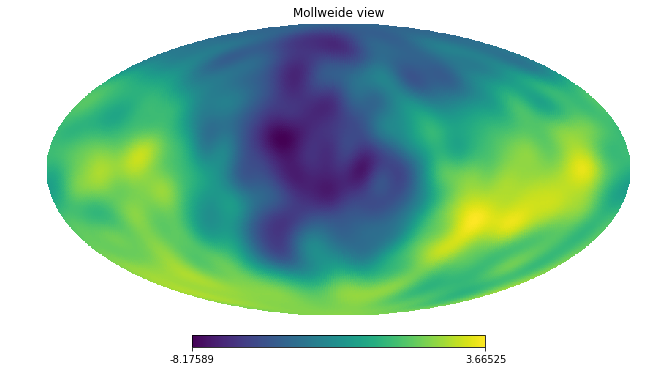

In [216]:
lmax = 20
l = hp.sphtfunc.Alm.getlm(lmax=lmax-1)[0]
scale = 10.0/(1.0+l)**2
_alm = np.random.normal(0,scale,int(lmax*(lmax+1)/2)) + 1j*np.random.normal(0,scale,int(lmax*(lmax+1)/2))
_map = hp.sphtfunc.alm2map(_alm,nside=nside)
hp.mollview(_map)

## Draw sample

In [217]:
def expit(x):
    return np.exp(x)/(1+np.exp(x))

In [218]:
sample = {}
sample['hpx'] = np.random.choice(np.arange(hp.nside2npix(nside)), size=int(1e6), replace=True)
sample['p'] = expit(_map[sample['hpx']])
sample['selected'] = (np.random.rand(len(sample['hpx'])) < sample['p']).astype(int)

## Accumulate sample in bins

In [219]:
k = stats.binned_statistic(sample['hpx'], sample['selected'], 
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='sum').statistic
n = stats.binned_statistic(sample['hpx'], sample['selected'], 
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='count').statistic

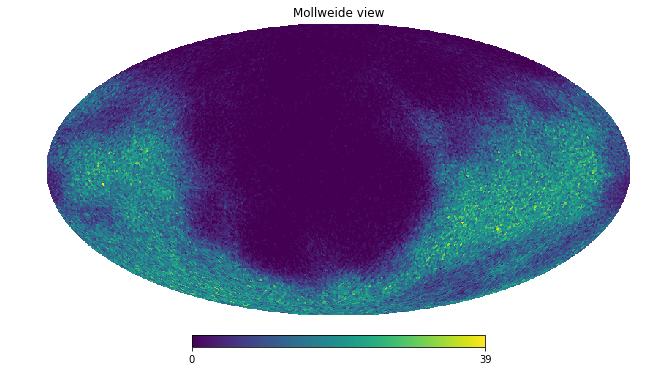

In [220]:
hp.mollview(k)

# MCMC - This doesn't work very well due to number of parameters!

## Likelihood function
Binomial likelihood function: $\ln\mathcal{L} \propto k\ln(p) + (n-k)\ln(1-p)$

In logit space: $\ln\mathcal{L} \propto kx + n\ln(1+\exp(x))$

In [221]:
lmax=6
nlm = int(lmax*(lmax+1)/2+0.01)

In [222]:
def loglike(params, k, n, nlm=55):
    
    x = hp.sphtfunc.alm2map(params[:nlm] + 1.j*params[nlm:],nside=nside,verbose=False)
    
    return np.sum( k*x - n*np.log(1+np.exp(x)) )

In [223]:
loglike(np.hstack((np.real(_alm), np.imag(_alm))), k, n, nlm=nlm)

ValueError: operands could not be broadcast together with shapes (21,) (399,) 

In [131]:
#ll = lambda x: 
def ll(x):
    return loglike(x, k, n, nlm=nlm)

In [134]:
ndim=2*nlm; nwalker=2*ndim; nstep=1000
p0_walkers=np.random.normal(0.,1., size=(nwalker,ndim))

In [123]:
p0_walkers.shape

(84, 42)

In [129]:
from multiprocessing import Pool

In [133]:
ncores=3
with Pool(ncores) as pool:
    sampler = emcee.EnsembleSampler(nwalker, ndim, ll, pool=pool)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
        pass

KeyboardInterrupt: 

In [135]:
sampler = emcee.EnsembleSampler(nwalker, ndim, ll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

In [136]:
flatchain = np.reshape(sampler.chain[:,250:], (-1,2*nlm))
mean_post = np.mean(flatchain, axis=0)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


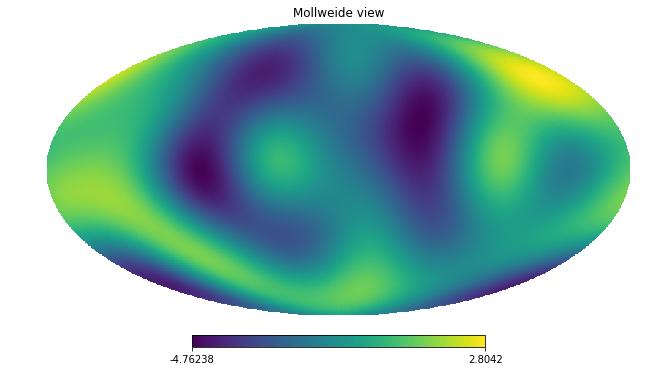

In [137]:
x = hp.sphtfunc.alm2map(mean_post[:nlm]+1.j*mean_post[nlm:],nside=nside)
hp.mollview(x)

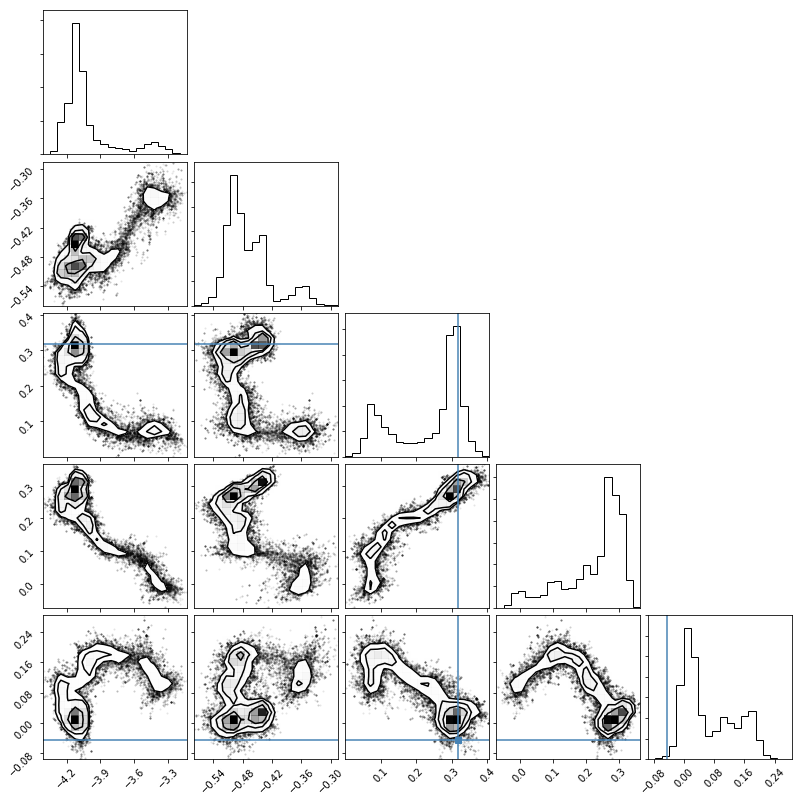

In [138]:
corner.corner(flatchain[:,:5], truths=np.real(_alm[:5]));

# Newton CG

## Gradient estimation
$$\frac{\partial \ln \mathcal{L}}{\partial a_{\mu\nu}} = \left( k - n\frac{\exp(x)}{1+\exp(x)}\right) Y_{\mu\nu}$$

In [224]:
lmax=20
nlm = int(lmax*(lmax+1)/2+0.01)

In [225]:
# generate sph harm grid
Ylm_grid = np.zeros((2*nlm, hp.nside2npix(nside)))
for ii in tqdm.tqdm_notebook(range(nlm)):
    alm_grid = np.zeros(nlm)
    alm_grid[ii]=1
    Ylm_grid[ii] = hp.sphtfunc.alm2map(alm_grid+0.j*alm_grid,nside=nside,verbose=False)
    Ylm_grid[nlm+ii] = hp.sphtfunc.alm2map(0.*alm_grid+1.j*alm_grid,nside=nside,verbose=False)

In [229]:
def nloglike_grad(params, k, n, nlm):
    x = np.sum(params*Ylm_grid.T, axis=1)
    
    logl = np.sum( k*x - n*np.log(1+np.exp(x)) )
    
    grad_norm = k - n*np.exp(x)/(1+np.exp(x))
    grad = np.sum(grad_norm * Ylm_grid, axis=1)
    
    return -logl, -grad

In [227]:
nloglike_grad(np.hstack((np.real(_alm), np.imag(_alm))), k, n, nlm=nlm)

(352108.6432608709,
 array([-1.67927387e+01,  5.24798950e+01, -8.97585789e+01, -7.00791921e+01,
         6.63503867e+01,  1.50758231e+01,  7.49238177e+01, -1.31980175e+02,
         7.51394696e+01,  1.95020180e+01, -9.28974182e+00, -1.00614715e+02,
        -3.40835941e+01,  9.15393672e+01, -2.05203805e+01,  1.43704702e+02,
        -9.42493476e+01,  2.80028890e+01, -1.13039266e+00,  6.58454878e+01,
         2.49271484e+02, -2.82070178e+02,  4.98274336e+01, -6.54302390e+01,
        -9.32542631e+00,  2.62961978e+02, -2.96785936e+02,  1.88506199e+02,
        -5.95619365e+01,  1.90612626e+02,  3.36574909e+01, -3.29800936e+02,
         1.11114485e+02, -1.32726289e+02,  2.13430128e+02, -2.64646780e+01,
        -1.29576726e+02,  8.37235810e+01,  8.85313288e+01,  2.27471436e+02,
        -3.07568281e+02,  1.03610285e+02, -6.24461270e+01,  1.43112097e+02,
        -7.42769471e+01,  1.44585208e+01, -1.60893405e+02,  1.06164046e+02,
         1.13650369e+02,  1.78608977e+01,  2.13666770e+01, -7.167431

In [232]:
p0=np.random.normal(0.,1., size=2*nlm)
result = scipy.optimize.minimize(nloglike_grad, p0, method='Newton-CG', args=(k,n,nlm), jac=True)
result

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


     fun: 351903.93029606255
     jac: array([ 2.05403337e-02, -1.64212040e-02, -6.86682616e-03, -1.35112884e-03,
       -4.62792542e-04, -8.55023958e-03,  1.25606198e-03,  3.12213096e-03,
        2.15663866e-03,  9.10763204e-03,  2.34081040e-02, -1.55419294e-02,
        1.21618723e-02, -5.88137008e-03, -9.23060445e-04,  4.59454027e-04,
       -5.20345708e-03, -3.81851668e-03,  2.59716478e-03,  1.57624695e-02,
       -2.51538693e-03, -8.09953931e-03, -5.01270086e-03,  1.22326635e-02,
        1.88124887e-02, -9.89829724e-04,  1.11632595e-02,  7.78615038e-03,
        5.22736176e-03,  5.32147090e-03, -4.68287900e-03,  9.38106591e-03,
       -3.90986627e-03,  3.03991481e-03,  2.38515329e-03, -1.01454960e-02,
        1.15511364e-03,  3.22294842e-03, -1.22457205e-02, -6.42161555e-04,
        6.45011713e-03,  6.75734830e-03, -4.14542625e-03, -8.38912610e-03,
        1.94433913e-04,  1.86609838e-03, -7.07051457e-03,  4.23282165e-03,
       -1.15383060e-03, -1.49933190e-02,  1.93938960e-03, -2.

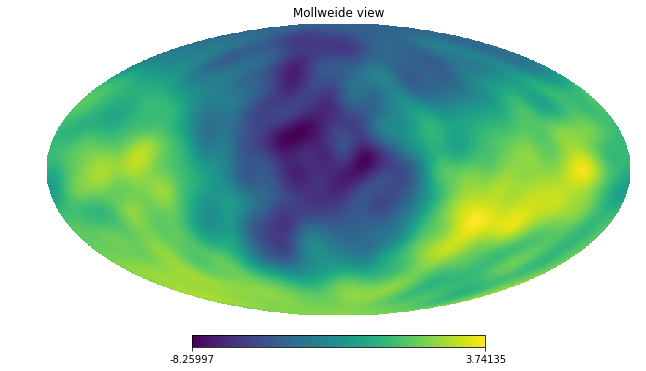

In [233]:
x = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(x)

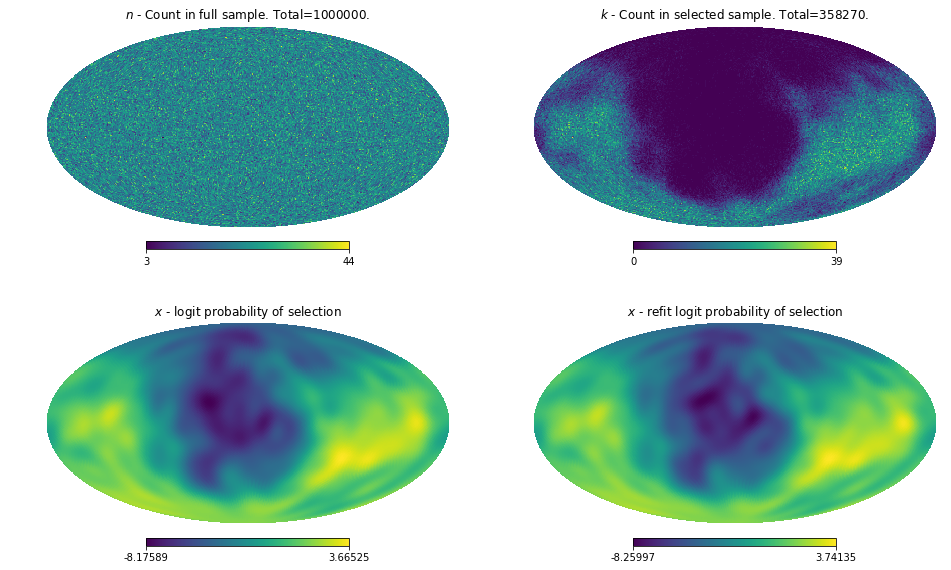

In [235]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

plt.sca(ax[0,0])
hp.mollview(n, hold=True, title=r'$n$ - Count in full sample. Total=%d.' % np.sum(n))
plt.sca(ax[0,1])
hp.mollview(k, hold=True, title=r'$k$ - Count in selected sample. Total=%d.' % np.sum(k))

plt.sca(ax[1,0])
_map = hp.sphtfunc.alm2map(_alm,nside=nside, verbose=False)
hp.mollview(_map, hold=True, title=r'$x$ - logit probability of selection')

plt.sca(ax[1,1])
_map = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(_map, hold=True, title=r'$x$ - refit logit probability of selection')

plt.savefig('figs/astsf_dummy_sphharm_lmax%d.png' % lmax, bbox='tight', dpi=200)

# Fit to true data

In [303]:
import h5py
nside=32

In [245]:
data = {}
mag = 20.
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = hf[str(magid)]['n'][...]
    data['k'] = hf[str(magid)]['k'][...]
    data['hpx'] = hf[str(magid)]['hpx'][...]

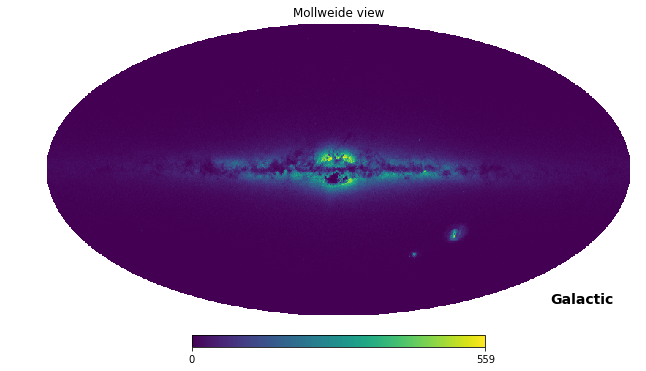

In [249]:
arr = np.zeros(hp.nside2npix(128))
arr[data['hpx']] = data['k']
hp.mollview(arr, nest=True, coord=['C','G'])

In [268]:
# generate sph harm grid
Ylm_grid = np.zeros((2*nlm, hp.nside2npix(nside)))
ring2nest = hp.nest2ring(nside, np.arange(hp.nside2npix(nside)))
for ii in tqdm.tqdm_notebook(range(nlm)):
    alm_grid = np.zeros(nlm)
    alm_grid[ii]=1
    Ylm_grid[ii] = hp.sphtfunc.alm2map(alm_grid+0.j*alm_grid,nside=nside,verbose=False)[ring2nest]
    Ylm_grid[nlm+ii] = hp.sphtfunc.alm2map(0.*alm_grid+1.j*alm_grid,nside=nside,verbose=False)[ring2nest]

In [306]:
Ylm_grid=Ylm_grid.T

In [312]:
def nloglike_grad(params, k, n, hpx, nlm):
    x = np.sum(params*Ylm_grid, axis=1)[hpx]
    
    exp_x = np.exp(x)
    log1p_exp_x = np.log1p(exp_x)
    
    logl = np.sum( k*x - n*log1p_exp_x )
    
    grad_norm = k - n*exp_x/log1p_exp_x
    grad = np.sum(grad_norm[:,None] * Ylm_grid[hpx], axis=1)
    
    return -logl, -grad

In [309]:
Ylm_grid.shape

(196608, 420)

In [313]:
%timeit nloglike_grad(p0, data['k'],data['n'],data['hpx'],nlm)

918 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [299]:
%timeit nloglike_grad(p0, data['k'],data['n'],data['hpx'],nlm)

956 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [317]:
%timeit x = np.sum(p0*Ylm_grid, axis=1)#[data['hpx']]

67.3 ms ± 808 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [294]:
%timeit np.log1p(np.exp(x))

6.16 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [295]:
%timeit np.log(1+np.exp(x))

7.65 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [305]:
%timeit np.sum(Ylm_grid, axis=0)

66.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [281]:
p0=np.random.normal(0.,1., size=2*nlm)
result = scipy.optimize.minimize(nloglike_grad, p0, method='Newton-CG', 
                                 args=(data['k'],data['n'],data['hpx'],nlm), jac=True)
result

     fun: 796544.9008366253
     jac: array([-0.02314287,  0.01065522,  0.01349295, -0.01842746,  0.04937866,
       -0.03270201,  0.00429707,  0.02316283, -0.04259027,  0.00212463,
       -0.00831156,  0.04112825, -0.03733593,  0.00782711,  0.00037221,
        0.00572685,  0.01445518, -0.04441173,  0.0634857 , -0.04913839,
       -0.02287013, -0.02808538, -0.01095962, -0.01943482, -0.00476187,
       -0.01324316,  0.04095274, -0.02551156,  0.01635008, -0.02966488,
        0.0038684 ,  0.02019909, -0.01214724,  0.04888774, -0.02445988,
        0.02259318, -0.03762789,  0.00406144,  0.01252773,  0.00716579,
        0.03125345, -0.02961243,  0.02170751, -0.02106722,  0.07324775,
       -0.02741093, -0.00243777, -0.00099981,  0.04807291, -0.05803136,
        0.01139847, -0.00669924,  0.03017896,  0.00183561, -0.04682262,
        0.0568872 , -0.05219506,  0.02286904, -0.01514619,  0.00610802,
        0.02494765, -0.01101356, -0.01973909,  0.01006653, -0.04592523,
        0.04350943, -0.033

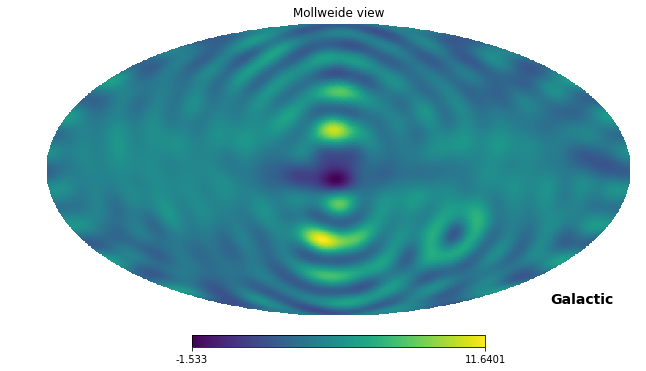

In [283]:
x = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(x, coord=['C','G'])

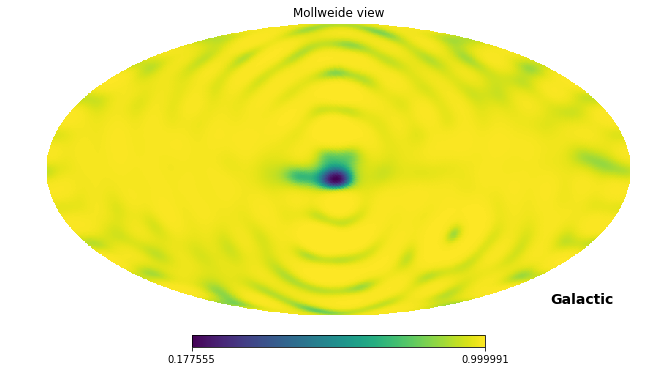

In [284]:
hp.mollview(expit(x), coord=['C','G'])